## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 0 : Importing required packages and calculating chessboard corners

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chessboard_images = []  #array to hold chessboard images
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        chessboard_images.append(img)
        


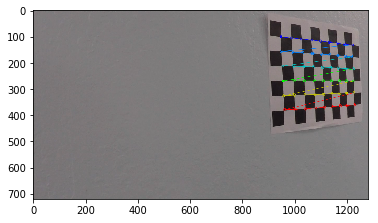

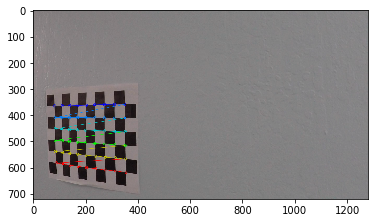

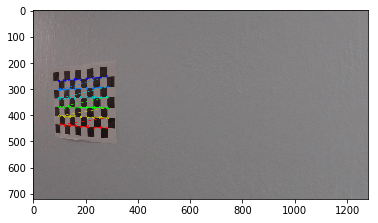

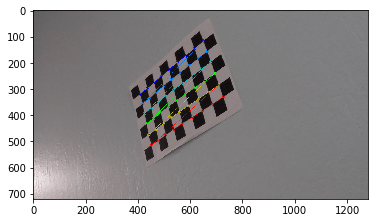

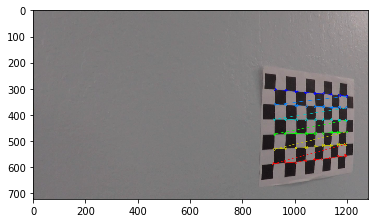

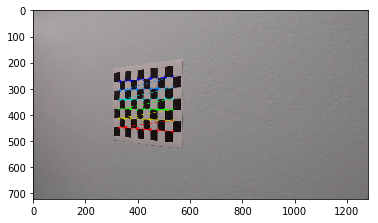

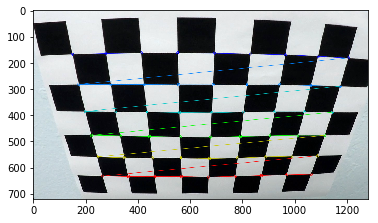

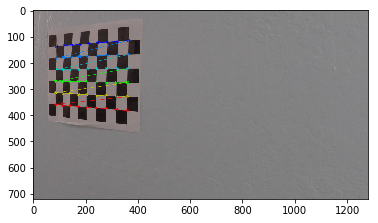

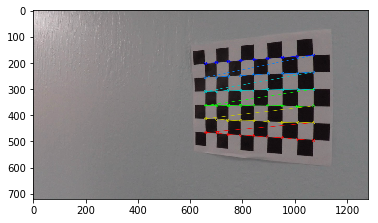

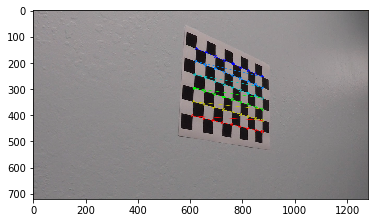

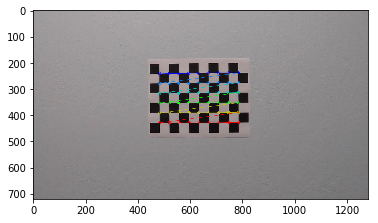

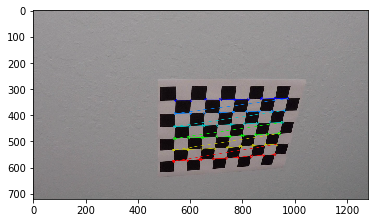

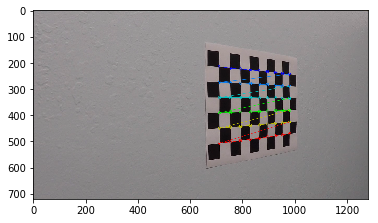

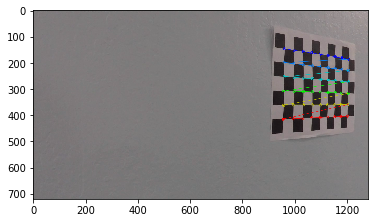

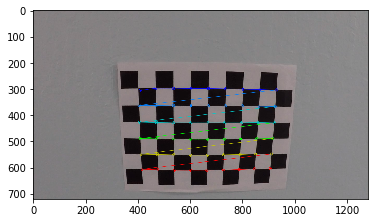

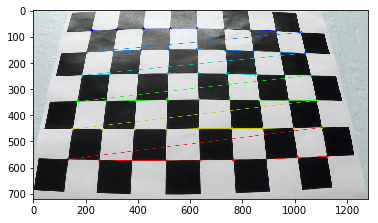

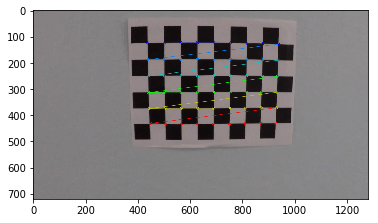

In [2]:
for i in range(len(chessboard_images)):
    plt.imshow(chessboard_images[i])
    plt.show()

## Step 1 : Computing camera calibration and applying distortion  correction to new images

In [3]:
def calibrate_camera_img( img):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img.shape[:2],None, None)
    
    return ret, mtx, dist, rvecs, tvecs
    

In [4]:
def visualization(img1, title1, img2, title2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax2.imshow(img2, cmap = 'gray')
    ax2.set_title(title2)

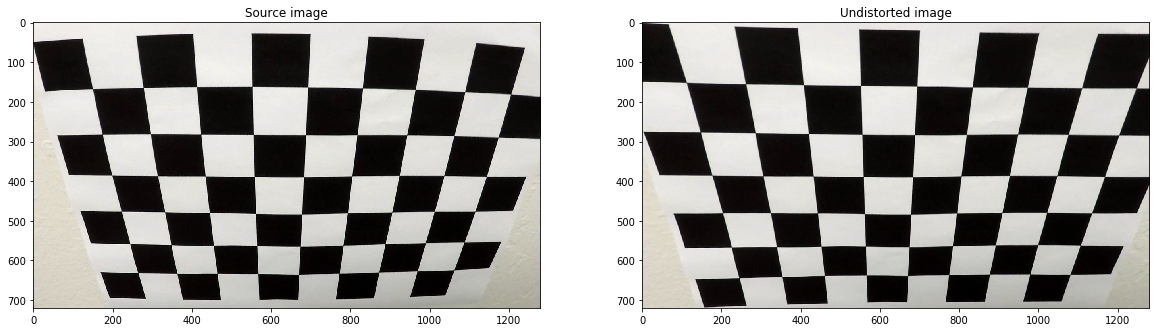

In [5]:
test_img = mpimg.imread('camera_cal/calibration2.jpg')
undistort_img = 'output_images/undistort_img.jpg'

ret, mtx, dist, revecs, tvecs = calibrate_camera_img(test_img)

undist = cv2.undistort(test_img, mtx, dist, None, mtx)

cv2.imwrite(undistort_img, undist)

visualization(test_img, 'Source image', undist, 'Undistorted image')



## Step 2: Creating thresholded Binary Images:

In [6]:
def abs_sobel(img, orient = 'x', thresh_min = 0, thresh_max = 255):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1 , 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0 , 1)
        
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    sxbinary = np.zeros_like(scaled_sobel)
    
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

In [7]:
source_img = mpimg.imread('./test_images/test1.jpg')

img = cv2.undistort(source_img, mtx, dist, None, mtx)

#img = cv2.GaussianBlur(img, (5,5), 0 )

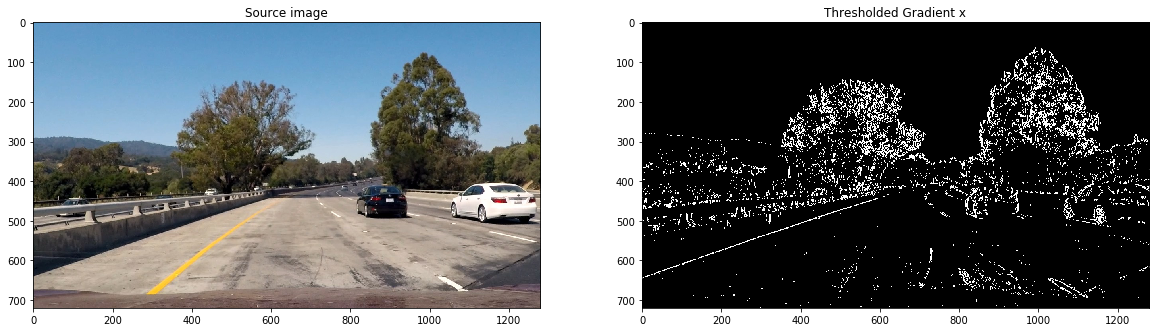

In [8]:
sobelx = abs_sobel(img, orient = 'x', thresh_min = 20, thresh_max = 100)

visualization(source_img, 'Source image', sobelx , 'Thresholded Gradient x')

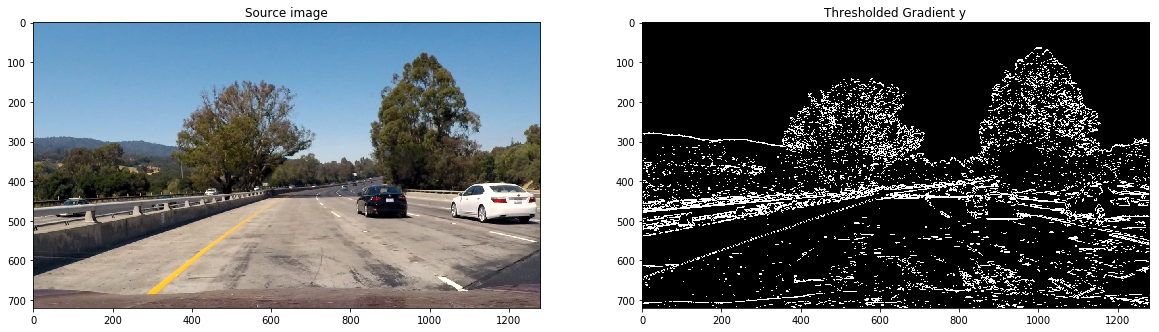

In [9]:
sobely = abs_sobel(img, orient = 'y', thresh_min = 20, thresh_max = 100)

visualization(source_img, 'Source image', sobely , 'Thresholded Gradient y')

In [10]:
def mag_thresh(img , sobel_kernel =3 , mag_thresh = (0,255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1 , 0, ksize = sobel_kernel)
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0 , 1, ksize = sobel_kernel)
        
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255 * magnitude / np.max(magnitude))
    
    magbinary = np.zeros_like(scaled_sobel)
    
    magbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return magbinary

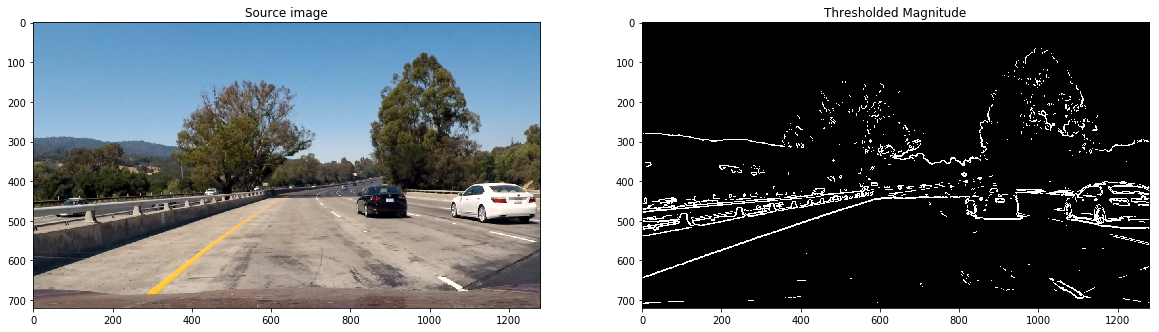

In [11]:
magbinary = mag_thresh(img, sobel_kernel = 9, mag_thresh =(60,180))

visualization(source_img, 'Source image', magbinary , 'Thresholded Magnitude')

In [12]:
def dir_threshold(img, sobel_kernel = 3, thresh= (0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    dirgrad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    dirbinary = np.zeros_like(dirgrad)
    
    dirbinary[(dirgrad >= thresh[0]) & (dirgrad <= thresh[1])] = 1
    
    return dirbinary

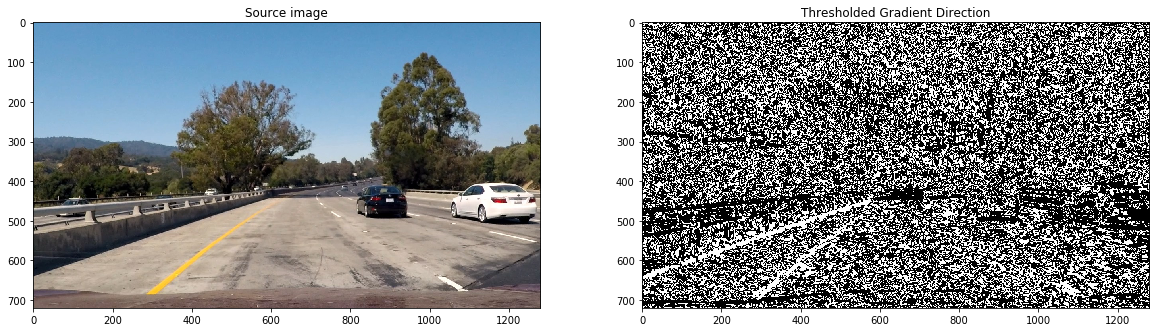

In [13]:
dirbinary = dir_threshold(img, sobel_kernel = 19, thresh= (0.7,1.3))

visualization(source_img, 'Source image', dirbinary , 'Thresholded Gradient Direction')



In [14]:
def hls_select(img, threshs=(0,255), threshl = (0,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    s = hls[:,:,2]
    
    l = hls[:,:,1]
    hls_binary_s = np.zeros_like(s)
    
    #hls_binary_l = np.zeros_like(l)
    
    #hls_binary = np.zeros_like(s)
    
    hls_binary_s[(s> threshs[0]) & (s <= threshs[1])] = 1
    
    #hls_binary_l[(l> threshl[0]) & (l <= threshl[1])] = 1
    
    #hls_binary[((hls_binary_s == 1) | (hls_binary_l == 1) )] = 1
    
    return hls_binary_s

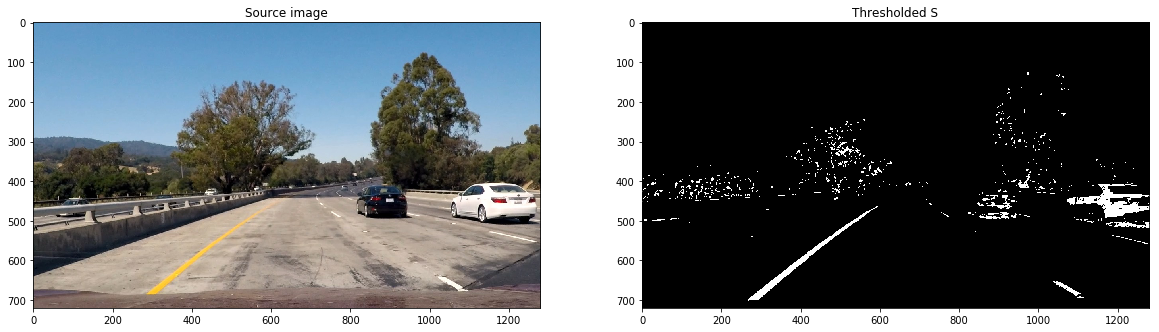

In [15]:
hls_binary = hls_select(img, threshs= (145,255), threshl = (120,255))

visualization(source_img, 'Source image', hls_binary , 'Thresholded S')

## Step 3 : Combined thresholds to detect the line:

In [16]:
def threshold_combined(sobelx, sobely, magbinary, dirbinary, hls_binary):
    
    combined = np.zeros_like(dirbinary)
    
    combined[((sobelx == 1) & (sobely ==1)) | ((magbinary == 1) & (dirbinary==1)) | (hls_binary == 1)] = 1
    
    return combined

(720, 1280, 3)


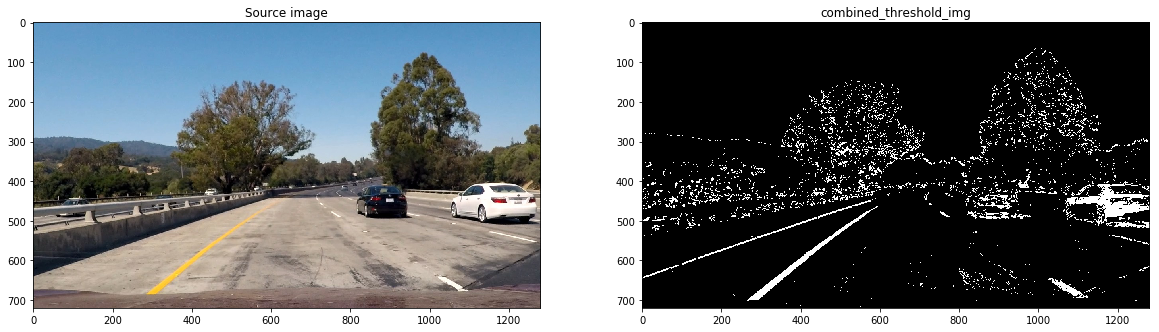

In [17]:
combined_threshold_img = threshold_combined(sobelx, sobely, magbinary, dirbinary, hls_binary)

visualization(source_img, 'Source image', combined_threshold_img , 'combined_threshold_img')

print(source_img.shape)

## Step 4: Perspective Transform:

In [18]:
def perspective_transform(img, src, dst):
    
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective( img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped, Minv

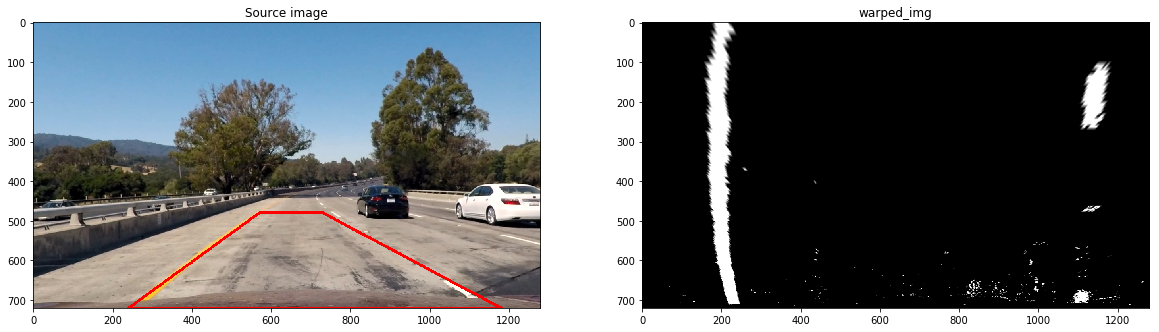

In [43]:
src = np.float32([[270,720],[590,470],[730,470],[1150,720]])

dst = np.float32([[250,720],[250,0],[1100,0],[1100,720]])

warped_img, Minv = perspective_transform(combined_threshold_img, src ,dst)
                   
src_pts =np.array([[240,720],[570,480],[730,480],[1180,720]], np.int32)

src_pts = src_pts.reshape((-1,1,2))

img_copy = img.copy()

cv2.polylines(img_copy, [src_pts], True, (255,0,0), thickness = 5)

visualization(img_copy, 'Source image', warped_img , 'warped_img')

               
                   

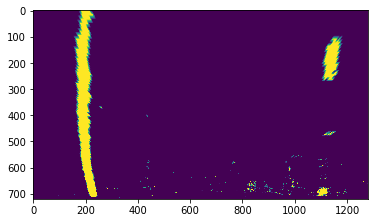

In [44]:
plt.imshow(warped_img)

## Step 5: Histogram

In [45]:
def histo(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis = 0)
    
    return histogram
    

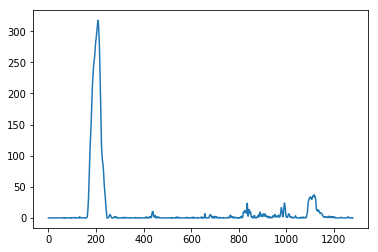

In [46]:
Hist =histo(warped_img)

plt.plot(Hist)

## Step 6: Detecting lines

In [47]:
def finding_lane_pixels(img, out_img):
    
    hist = histo(img)
    
    midpoint = np.int(hist.shape[0]//2)
    
    leftx_base = np.argmax(hist[:midpoint])
    
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    nwindows = 9
    
    minpix = 50
    
    margin = 100
    
    window_height = np.int(img.shape[0]//nwindows)
    
    nonzero = img.nonzero()
    
    nonzerox = np.array(nonzero[1])
    
    nonzeroy = np.array(nonzero[0])
    
    leftx_current = leftx_base
    
    rightx_current = rightx_base
    
    left_lane_inds = []
    
    right_lane_inds = []
    
    for i in range(nwindows):
        
        y_low = img.shape[0] - (i+1)*window_height
        
        y_high = img.shape[0] - i*window_height
        
        xleft_low    = leftx_current  - margin
        xleft_high   = leftx_current  + margin
        xright_low   = rightx_current - margin
        xright_high  = rightx_current + margin
        
        left_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
        (nonzerox >= xleft_low) &  (nonzerox < xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
        (nonzerox >= xright_low) &  (nonzerox < xright_high)).nonzero()[0]
        
        cv2.rectangle(out_img,(xleft_low,y_low),
        (xleft_high,y_high),(0,255,0), 8) 
        cv2.rectangle(out_img,(xright_low,y_low),
        (xright_high,y_high),(0,255,0), 8) 
        
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

    
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    leftfit = np.polyfit(lefty, leftx ,2)
    rightfit = np.polyfit(righty, rightx ,2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    try:
        
        leftfitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
        
        rightfitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
        
    except:
        
        print('function failed')
        
        leftfitx = 1*ploty**2 + 1*ploty
        
        rightfitx = 1*ploty**2 + 1*ploty
        
    out_img[lefty,leftx] = [255,0,0]
    
    out_img[righty, rightx] = [0,0,255]
    
    plt.plot(leftfitx, ploty, color = 'yellow')
    
    plt.plot(rightfitx, ploty, color = 'yellow')
    
    
    return out_img, (leftfit, rightfit), (leftx, lefty, rightx, righty), ploty,( leftfitx,rightfitx) 
    

    

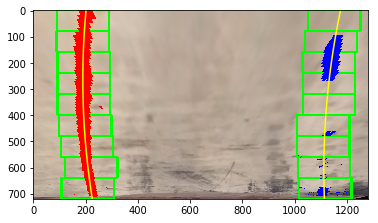

In [48]:
out_warped_img, Minv = perspective_transform(img, src, dst)

out_img, linefit , xy_points, ploty , fitx = finding_lane_pixels(warped_img, out_warped_img)


plt.imshow(out_img)

In [49]:
def search_around(img, out_img, linefit = None):
    
    
    if linefit is None:
         _ , linefit , _ , _ , _ = finding_lane_pixels(warped_img, out_warped_img)
    
    margin = 100
    
    nonzero = img.nonzero()
    
    nonzerox = np.array(nonzero[1])
    
    nonzeroy = np.array(nonzero[0])
    
    leftfit, rightfit = linefit
    
    left_lane_inds = ((nonzerox > (leftfit[0]*(nonzeroy**2)+ leftfit[1]*nonzeroy +
                                   leftfit[2] - margin)) & (nonzerox <(leftfit[0]*(nonzeroy**2)+ 
                                   leftfit[1]*nonzeroy + leftfit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (rightfit[0]*(nonzeroy**2)+ rightfit[1]*nonzeroy +
                                   rightfit[2] - margin)) & (nonzerox <(rightfit[0]*(nonzeroy**2)+ 
                                   rightfit[1]*nonzeroy + rightfit[2] + margin))).nonzero()[0]
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (leftx.size == 0 or rightx.size == 0):
        return finding_lane_pixels(warped_img, out_warped_img)
        
    leftfit = np.polyfit(lefty, leftx, 2)
    rightfit = np.polyfit(righty, rightx,2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        
    leftfitx = leftfit[0]*ploty**2 + leftfit[1]*ploty + leftfit[2]
        
    rightfitx = rightfit[0]*ploty**2 + rightfit[1]*ploty + rightfit[2]
        
    window_img = np.zeros_like(out_img)
    
    out_img[lefty,leftx] = [255,0,0]
    
    out_img[righty, rightx] = [0, 0,255] 
    
    left_line_window1 = np.array([np.transpose(np.vstack([leftfitx - margin, ploty]))])
    
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([leftfitx + margin, ploty])))])
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
     
    right_line_window1 = np.array([np.transpose(np.vstack([rightfitx - margin, ploty]))])
    
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rightfitx + margin, ploty])))])
    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]),(0,255,0))
    
    cv2.fillPoly(window_img, np.int_([right_line_pts]),(0,255,0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.plot(leftfitx, ploty, color='yellow')
    
    plt.plot(rightfitx, ploty, color='yellow')
    
    fitx = (leftfitx, rightfitx)
    
    return result, linefit, fitx
    
    
     

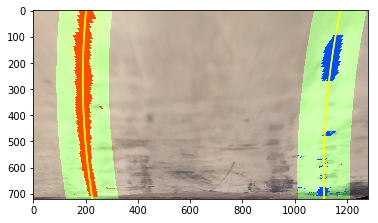

In [50]:
out_warped_img1, Minv = perspective_transform(img, src, dst)

result, _, _ = search_around(warped_img, out_warped_img1)
 
plt.imshow(result)

## Step 7 : Calculating curvature and camera offset:

In [51]:
def curvature(ploty, leftfitx, rightfitx):
    
    ym_per_pix = 30/720 
    
    xm_per_pix = 3.7/700
    
    yeval = np.max(ploty)
    
    leftfit = np.polyfit(ploty*ym_per_pix, leftfitx*xm_per_pix,2)
    
    rightfit = np.polyfit(ploty*ym_per_pix, rightfitx*xm_per_pix,2)
    
    left_curvature = ((1+(2*leftfit[0]*yeval*ym_per_pix + leftfit[1])**2)**1.5)/np.absolute(2*leftfit[0])
    
    right_curvature = ((1+(2*rightfit[0]*yeval*ym_per_pix + rightfit[1])**2)**1.5)/np.absolute(2*rightfit[0])
    
    return left_curvature, right_curvature

In [52]:
leftfitx, rightfitx = fitx[0], fitx[1]

left_curve, right_curve = curvature(ploty, leftfitx, rightfitx)

print('Left curve - {}m\nRight Curve - {}m'.format(left_curve, right_curve))

Left curve - 940.9685973261113m
Right Curve - 954.8368587422987m


In [53]:
def camera_offset(leftfitx, righfittx, img_shape = img.shape):
    
    camera_location = img.shape[1]//2
    
    lane_centre = (leftfitx[-1] + rightfitx[-1])/2
    
    offset = (camera_location - lane_centre) * (3.7/700)
    
    return offset

In [54]:

cameraoffset = camera_offset(leftfitx, rightfitx)

print('Camera offset from centre = {}m'.format(cameraoffset))

Camera offset from centre = -0.15589726441657897m


## Step 8 : Warping the fit from rectified image onto the original image

In [55]:
def boundary(img, warp, leftfitx, rightfitx, ploty, Minv):
    
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    left_line = np.array([np.transpose(np.vstack([leftfitx, ploty]))])
    
    right_line = np.array([np.flipud(np.transpose(np.vstack([rightfitx, ploty])))])
    
    pts = np.hstack((left_line, right_line))
    
    cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
    
    img_shape = (img.shape[1], img.shape[0])
    
    newwarp = cv2.warpPerspective(color_warp, Minv, img_shape)
    
    final = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return final
     

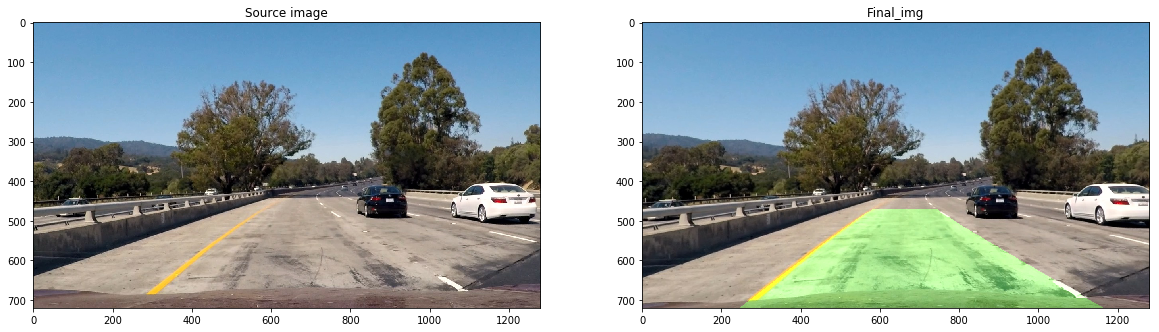

In [56]:
final_img = boundary(img, warped_img, leftfitx, rightfitx, ploty, Minv)

visualization(source_img, 'Source image', final_img , 'Final_img')


## Step 9 : Add Curvature and offset to the image:

In [57]:
def add_info(img, leftfitx, rightfitx, ploty):
    
    left_curve, right_curve = curvature(ploty, leftfitx, rightfitx)
    
    cameraoffset = camera_offset(leftfitx, rightfitx)
    
    final_copy = img.copy()
    
    cv2.putText(final_copy, 'Left lane curvature: {}m'.format(np.round(left_curve)), 
                (170, 60), cv2.FONT_HERSHEY_SIMPLEX , 2, (50,255,50), 5)
    
    cv2.putText(final_copy, 'Right lane curvature: {}m'.format(np.round(right_curve)), 
                (170, 130), cv2.FONT_HERSHEY_SIMPLEX , 2, (50,255,50), 5)
    
    cv2.putText(final_copy, 'Camera offset Dist: {:.3f}m'.format(cameraoffset), 
                (170, 200), cv2.FONT_HERSHEY_SIMPLEX , 2, (255,255,50), 5)
    
    return final_copy
    
    

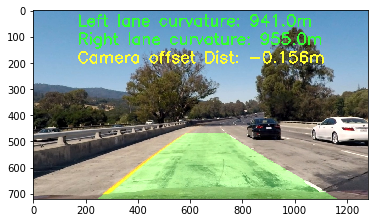

In [58]:
finalized = add_info(final_img, leftfitx, rightfitx, ploty)

plt.imshow(finalized)

In [59]:
class Pipeline:
    
    def __init__(self,image):
        
        image = glob.glob(image)
        
        self.ret, self.mtx, self.dist, self.revecs, self.tvecs = calibrate_camera_img(img)
        
        self.linefit = None
        
    def __call__(self, img):

        
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        sobelx = abs_sobel(undist, orient = 'x', thresh_min = 20, thresh_max = 100)

        sobely = abs_sobel(undist, orient = 'y', thresh_min = 20, thresh_max = 100)

        magbinary = mag_thresh(undist, sobel_kernel = 9, mag_thresh =(60,180))

        dirbinary = dir_threshold(undist, sobel_kernel = 19, thresh= (0.7,1.3))

        hls_binary = hls_select(undist, threshs= (145,255), threshl = (120,255))

        combined_threshold_img = threshold_combined(sobelx, sobely, magbinary, dirbinary, hls_binary)

        src = np.float32([[270,720],[590,470],[730,470],[1150,720]])

        dst = np.float32([[250,720],[250,0],[1100,0],[1100,720]])

        warped_img, Minv = perspective_transform(combined_threshold_img, src ,dst)

        #out_warped_img, _ = perspective_transform(img, src, dst)

        #out_img, linefit , xy_points, ploty , fitx = finding_lane_pixels(warped_img, out_warped_img)

        out_warped_img1, _ = perspective_transform(undist, src, dst)

        result, self.linefit, fitx = search_around(warped_img, out_warped_img1, self.linefit)

        final_img = boundary(undist, warped_img, fitx[0], fitx[1], ploty, Minv)

        finalized = add_info(final_img,  fitx[0], fitx[1], ploty)

        return finalized


In [60]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video ./project_solution.mp4
[MoviePy] Writing video ./project_solution.mp4



 24%|██▍       | 303/1261 [01:52<06:26,  2.48it/s]


 48%|████▊     | 605/1261 [03:51<04:28,  2.45it/s]


 72%|███████▏  | 907/1261 [05:54<02:25,  2.44it/s]


 96%|█████████▌| 1205/1261 [08:04<00:22,  2.45it/s]


100%|█████████▉| 1260/1261 [08:27<00:00,  2.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_solution.mp4 

CPU times: user 5min 54s, sys: 18.8 s, total: 6min 13s
Wall time: 8min 30s


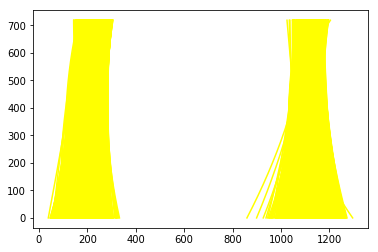

In [61]:
input_video = './project_video.mp4'
output_video = './project_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
pipeline = Pipeline('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(pipeline)

%time white_clip.write_videofile(output_video, audio=False)

In [62]:
output_video = './project_solution.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [63]:
def process_image(img, mtx = mtx, dist = dist):
    
    #ret, mtx, dist, revecs, tvecs = calibrate_camera_img(img)

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    sobelx = abs_sobel(undist, orient = 'x', thresh_min = 20, thresh_max = 100)

    sobely = abs_sobel(undist, orient = 'y', thresh_min = 20, thresh_max = 100)

    magbinary = mag_thresh(undist, sobel_kernel = 9, mag_thresh =(60,180))

    dirbinary = dir_threshold(undist, sobel_kernel = 19, thresh= (0.7,1.3))

    hls_binary = hls_select(undist, threshs= (145,255), threshl = (120,255))

    combined_threshold_img = threshold_combined(sobelx, sobely, magbinary, dirbinary, hls_binary)

    src = np.float32([[240,720],[570,470],[730,470],[1180,720]])

    dst = np.float32([[250,720],[250,0],[1100,0],[1100,720]])

    warped_img, Minv = perspective_transform(combined_threshold_img, src ,dst)

    out_warped_img, _ = perspective_transform(undist, src, dst)
    
    out_img, linefit , xy_points, ploty , fitx = finding_lane_pixels(warped_img, out_warped_img)

    #out_warped_img1, _ = perspective_transform(img, src, dst)

    #result = search_around(warped_img, out_warped_img1)
    
    final_img = boundary(undist , warped_img, fitx[0], fitx[1], ploty, Minv)

    finalized = add_info(final_img, fitx[0], fitx[1], ploty)

    return finalized
    

[MoviePy] >>>> Building video ./challenge_video_solution.mp4
[MoviePy] Writing video ./challenge_video_solution.mp4



 64%|██████▎   | 309/485 [02:00<01:15,  2.33it/s]


100%|██████████| 485/485 [03:10<00:00,  2.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_solution.mp4 

CPU times: user 2min 10s, sys: 11.4 s, total: 2min 21s
Wall time: 3min 13s


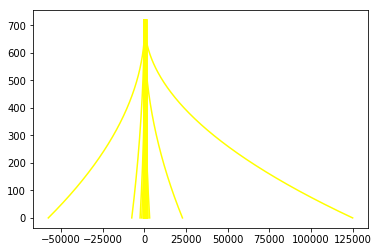

In [64]:
input_video = './challenge_video.mp4'
output1_video = './challenge_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output1_video, audio=False)

In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1_video))

In [ ]:
from moviepy.editor import *

output_video = './project_video_solution.mp4'

clip = (VideoFileClip('./project_video_solution.mp4').subclip((0,00.0),(0,05.9)).resize(0.3))

clip.write_gif('./project_video.gif')



[MoviePy] Building file ./project_video.gif with imageio


 98%|█████████▊| 145/148 [00:18<00:00,  7.95it/s]